In [52]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from utils import getphantom_mv
from context import mvtomo
from mvtomo.algorithms_mv import MLEM, OSEM, CGNE
from mvtomo.utils import volshow, plot_imgs


In [67]:
from utils import getphantom_mv
L = 128
mvtomo.set_backend("voxelproj", z_order=2)
phantom, sino, sino_roi,angles_scout,angles_interior = getphantom_mv(L = L)
sino_noisy = mvtomo.add_poisson(sino, 1000)
sino_roi_noisy = mvtomo.add_poisson(sino_roi, 1000)

(256, 10, 384)
(256, 90, 128)


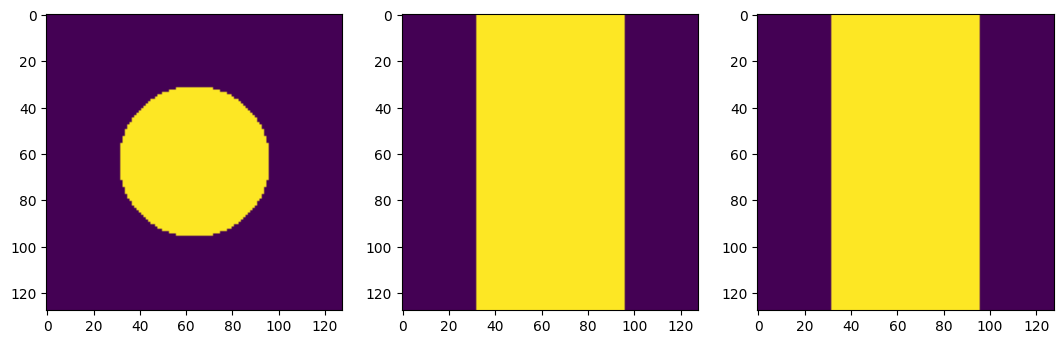

In [68]:
from skimage.metrics import peak_signal_noise_ratio
# mask ROI metric for 'good' interior support
A_roi = mvtomo.get_operator(phantom, sino_roi, angles_interior)
mask = A_roi.T(np.ones(sino_roi.shape)) >(0.9*sino_roi.shape[1])
mvtomo.volshow(mask)

def metric_roi(x, oracle):
    data_range = np.percentile(oracle,99)
    return peak_signal_noise_ratio(x[mask>0], oracle[mask>0], data_range=data_range)
    

In [69]:
kwargs = {
    'y':[sino_noisy,sino_roi_noisy],
    'angles':[angles_scout, angles_interior], 
}

In [71]:
n_iters = 50
mvtomo.set_backend("voxelproj", z_order=2)
rec_mlem = MLEM(np.ones(phantom.shape), **kwargs)
rec_osem = OSEM(np.ones(phantom.shape), **kwargs)
rec_cgne = CGNE(np.zeros(phantom.shape), **kwargs)
rec_cgne_nn = CGNE(np.zeros(phantom.shape), nn_step=3,**kwargs)

rec_mlem.set_metric(metric_roi)
rec_osem.set_metric(metric_roi)
rec_cgne.set_metric(metric_roi)
rec_cgne_nn.set_metric(metric_roi)

vol_mlem, psnr_mlem = rec_mlem(n_iters,oracle = phantom)
vol_osem, psnr_osem = rec_osem(n_iters,oracle = phantom)
vol_cgne, psnr_cgne = rec_cgne(n_iters,oracle = phantom)
vol_cgne_nn, psnr_cgne_nn = rec_cgne_nn(n_iters,oracle = phantom)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

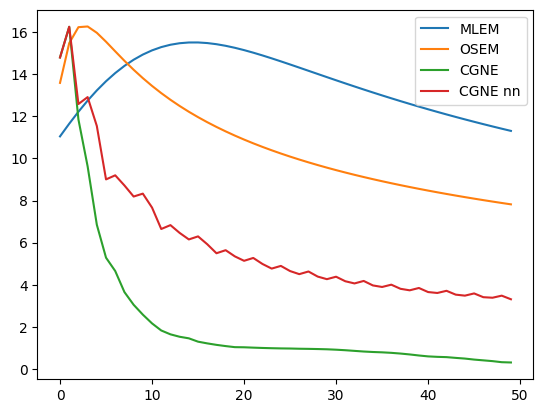

In [72]:
plt.figure()
plt.plot(psnr_mlem, label = 'MLEM')
plt.plot(psnr_osem, label = 'OSEM')
plt.plot(psnr_cgne, label = 'CGNE')
plt.plot(psnr_cgne_nn, label = 'CGNE nn')

plt.legend()


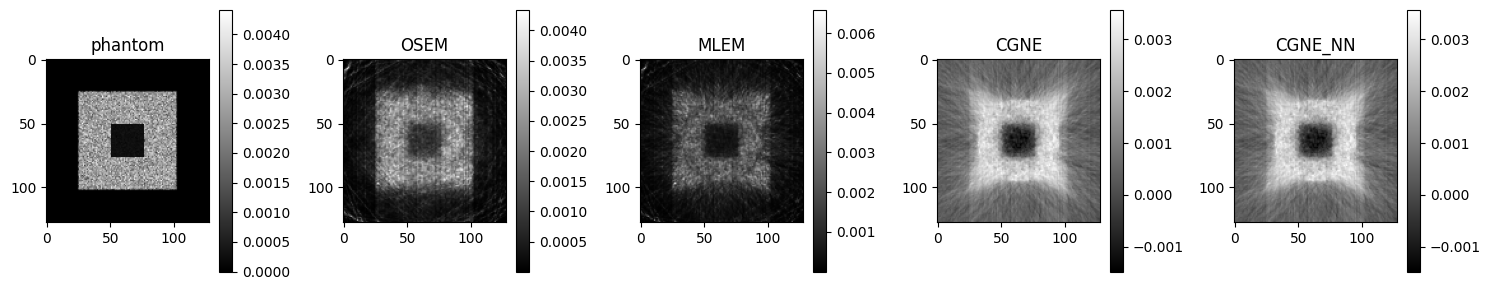

In [73]:
from mvtomo.utils import plot_imgs
plot_imgs(
    phantom=phantom[L//2],   
    OSEM=vol_osem[L//2],
    MLEM=vol_mlem[L//2],
    CGNE=vol_cgne[L//2],
    CGNE_NN=vol_cgne_nn[L//2],    
)
